### This notebook is for getting `g` from a prior on `a`, instead of by fitting an eccentric transit with a circular transit model. I demonstrate that you get the same result either way (as you should). Last updated 1/29/2021.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batman

import astropy.units as u
from astropy.timeseries import BoxLeastSquares
from scipy.optimize import curve_fit

import scipy.constants as c

import emcee
import corner

In [2]:
import photoeccentric as ph

%load_ext autoreload
%autoreload 2

In [3]:
#Kepler planets with spectroscopy
rho_lum = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/rhos/rho_lum.csv')

# ALL Kepler planets from exo archive
planets = pd.read_csv('/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/Data/exoplanetarchive/cumulative_kois.csv')

# Take the Kepler planet archive entries for the planets we have spectroscopy for
spectplanets = planets[planets['kepid'].isin(list(rho_lum.columns))]
spectplanets = spectplanets.reset_index()

In [4]:
#spectplanets

In [5]:
spectplanets.loc[spectplanets['kepid'] == 8733898]
#spectplanets.loc[spectplanets['kepler_name'] == "Kepler-446 b"]

,index,kepid,kepoi_name,kepler_name,koi_disposition,koi_vet_stat,koi_vet_date,koi_pdisposition,koi_score,koi_fpflag_nt,...,koi_dicco_mdec,koi_dicco_mdec_err,koi_dicco_msky,koi_dicco_msky_err,koi_dikco_mra,koi_dikco_mra_err,koi_dikco_mdec,koi_dikco_mdec_err,koi_dikco_msky,koi_dikco_msky_err
67,2321,8733898,K02842.01,Kepler-446 b,CONFIRMED,Done,8/16/18,CANDIDATE,1.000,0,...,0.12,0.14,0.12,0.14,-0.28,0.13,0.04,0.14,0.28,0.13
68,2322,8733898,K02842.02,Kepler-446 d,CONFIRMED,Done,8/16/18,CANDIDATE,0.992,0,...,0.32,0.30,0.32,0.27,-0.31,0.28,0.26,0.20,0.41,0.25
84,4122,8733898,K02842.03,Kepler-446 c,CONFIRMED,Done,8/16/18,CANDIDATE,0.947,0,...,0.00,0.26,0.54,0.30,-0.77,0.34,-0.08,0.31,0.78,0.34


In [6]:
kepname = "Kepler-446 b"

In [7]:
smass, smass_uerr, smass_lerr, srad, srad_uerr, srad_lerr, ldmod, ldm_c1, ldm_c2 = ph.stellar_params_from_archive(spectplanets, kepname)
period, period_uerr, period_lerr, rprs, rprs_uerr, rprs_lerr, a, a_uerr, a_lerr, i, e, w = ph.planet_params_from_archive(spectplanets, kepname)

smass_err = np.mean((smass_uerr, np.abs(smass_lerr)))
srad_err = np.mean((srad_uerr, np.abs(srad_lerr)))
period_err = np.mean((period_uerr, np.abs(period_lerr)))
rprs_err = np.mean((rprs_uerr, np.abs(rprs_lerr)))
a_err = np.mean((a_uerr, np.abs(a_lerr)))

print('Stellar mass: ', smass, 'Stellar radius: ', srad)
print('Period: ', period, 'Rp/Rs: ', rprs)
print('a: ', a)
print('i: ', i)

Stellar mass:  0.32799999999999996 Stellar radius:  0.32799999999999996
Period:  1.5654126130000001 Rp/Rs:  0.048437
a:  16.57
i:  89.99


In [8]:
""" Create mass and radius arrays """

masses_dist = [np.random.normal(smass, np.mean((smass_uerr, np.abs(smass_lerr))), size=1000)]
radii_dist = [np.random.normal(srad, np.mean((srad_uerr, np.abs(srad_lerr))), size=1000)]
period_dist = [np.random.normal(period, np.mean((period_uerr, np.abs(period_lerr))), size=1000)]
rprs_dist = [np.random.normal(rprs, np.mean((rprs_uerr, np.abs(rprs_lerr))), size=1000)]
a_dist = [np.random.normal(a, np.mean((a_uerr, np.abs(a_lerr))), size=1000)]

###### Find the density of this "star" based on available information (mass and radius)


In [9]:
rho, ms, rs = ph.find_density_dist_symmetric(1, [smass], [smass_err], [srad], [srad_err])
rho[0].flatten();
rhos = rho[0]
rho_minuserr, rho_pluserr = ph.get_sigmas(rhos)

print('Mean density: ', np.mean(rhos))

100%|██████████| 1/1 [00:00<00:00, 646.47it/s]

Mean density:  14036.41865510608


A_rs prior:

In [10]:
def get_a_rs(rhos, periods):
    
    """Periods: days
    Rhos: kg/m^3"""
    
    a_rs = np.zeros(len(rhos))
    
    for i in range(len(rhos)):
        per_iter = periods[i]*86400
        rho_iter = rhos[i]
        
        a_rs[i] = ((per_iter**2)*((c.G*rho_iter)/(3*np.pi)))**(1.0/3.0)
        
    return a_rs

In [11]:
a_rs_kpcat = get_a_rs(rhos, period_dist[0])
a_rs_kpcat_sigmin, a_rs_kpcat_sigpls = ph.get_sigmas(a_rs_kpcat)

In [12]:
np.mean(a_rs_kpcat)

11.985648039271744

###### Density of this star based on Gaia and spectroscopy:

In [289]:
rhos_gaia = np.genfromtxt(r'/Users/sheilasagear/Dropbox (UFL)/Research/MetallicityProject/photoeccentric/notebooks/jan29_21_rhos_8733898.csv', delimiter=',')

print('Mean density: ', np.mean(rhos_gaia))


Mean density:  38949.79810546425


A_rs prior:

In [290]:
a_rs_gaia = get_a_rs(rhos_gaia, period_dist[0])

In [291]:
a_rs_gaia_sigmin, a_rs_gaia_sigpls = ph.get_sigmas(a_rs_gaia)

In [292]:
np.mean(a_rs_gaia)

17.066404887228245

##### Create a transit model with planet params above.

In [293]:
time = np.linspace(-24, 24, 10000)

In [294]:
def planetlc(time, per, rp, a, inc, e, w):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = e
    params.w = w                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    params.limb_dark = "quadratic"
    params.u = [0.1, 0.3]
    #params.limb_dark = "uniform"
    #params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)
    
    flux = m.light_curve(params)
    
    return flux

In [295]:
flux = planetlc(time, period, rprs, a, i, 0.0, 0.0)
#nflux = flux

# Adding gaussian noise
noise = np.random.normal(0,0.000005,len(time))
nflux = flux+noise

In [296]:
def planetlc_fitter(time, per, rp, a, inc, e, w):
    """e is a free parameter, with prior on a"""

    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 0.                        #time of inferior conjunction
    params.per = per                      #orbital period
    params.rp = rp                        #planet radius (in units of stellar radii)
    params.a = a                          #semi-major axis (in units of stellar radii)
    params.inc = inc                      #orbital inclination (in degrees)
    params.ecc = e                      #eccentricity
    params.w = w                        #longitude of periastron (in degrees)
    #params.limb_dark = "linear"
    #params.u = [0.3]
    params.limb_dark = "quadratic"
    params.u = [0.1, 0.3]
    #params.limb_dark = "uniform"
    #params.u = []

    #times to calculate light curve
    m = batman.TransitModel(params, time)

    flux = m.light_curve(params)

    return flux

## Fit transit

#### Astropy BLS

In [297]:
mod = BoxLeastSquares(time*u.day, nflux, dy=0.01)
periodogram = mod.autopower(0.2, objective="snr")

In [298]:
periodogram.period = np.asarray(periodogram.period)
per_guess = periodogram.period[int(np.median(np.argmax(periodogram.power)))]

#### Least-squares using BLS period guess

In [299]:
np.mean(a_rs_kpcat)+a_rs_kpcat_sigpls

13.598967901549795

In [300]:
a

16.57

In [301]:
np.mean(a_rs_gaia)+a_rs_gaia_sigmin

15.988493058686878

In [302]:
np.mean(a_rs_gaia)+a_rs_gaia_sigpls

18.242308700182463

In [303]:
bounds = ((-np.inf, -np.inf, np.mean(a_rs_gaia)+a_rs_gaia_sigmin, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.mean(a_rs_gaia)+a_rs_gaia_sigpls, np.inf, np.inf, np.inf))
#boundz = ((-np.inf, -np.inf, 14.0, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, 20.0, np.inf, np.inf, np.inf))
#bounds = ((-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf), (np.inf, np.inf, np.inf, np.inf, np.inf, np.inf))



In [304]:
np.mean(a_rs_gaia)

17.066404887228245

In [305]:
per_guess

1.5650047547887516

In [306]:
# Normally I would use the BLS depth, ingress+egress, etc. to guess the other planet params 
# but I'm not going to do that right now because I'm just testing my get_g function

p0 = [per_guess, rprs, np.mean(a_rs_gaia), i, 0.0, 0.0]
popt, pcov = curve_fit(planetlc_fitter, xdata=time, ydata=nflux, p0=p0, bounds=boundz)
fit = planetlc(time, *popt)



In [307]:
ttime = time[2470:2530]
tfit = fit[2470:2530]

In [308]:
p = popt[0]*86400 #4.99 days
perr = 0.001*86400

rprs = popt[1] #0.0704 stellar radii
rprserr = 0.001

a = popt[2] #stellar radii

i = popt[3] #degrees 


T14n = ph.get_T14(p, rprs, a, i)
T14err = 0.0001*86400

T23n = ph.get_T23(p, rprs, a, i)
T23err = 0.0001*86400

In [309]:
popt

array([ 1.56541268e+00,  4.84414432e-02,  1.65479492e+01,  9.01778878e+01,
       -1.40662992e-06, -3.43351105e-01])

In [310]:
p/86400.

1.5654126767974612

In [311]:
rprs

0.04844144318072609

In [312]:
i

90.17788780546579

In [313]:
a

16.54794916612691

(-0.1, 0.1)

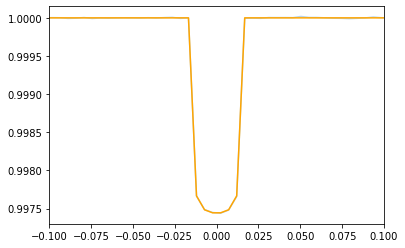

In [314]:
plt.plot(time, nflux, alpha=0.3)
plt.plot(time, fit, c='orange')
plt.xlim(-0.1, 0.1)

# Kepler Catalog Rhos

In [315]:
gs_t, rhoc, rhoe, T14s, T23s = ph.get_g_distribution(rhos, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 15073.87it/s]


In [316]:
g_mean

1.3968345913637634

In [317]:
g_sigma

0.1695866728755423

In [318]:
np.mean(rhoe)

14044.578518140968

In [319]:
np.mean(rhoc)

35047.24622395025

# Gaia Rhos

In [320]:
gs_t, rhoc, rhoe, T14s, T23s = ph.get_g_distribution(rhos_gaia, p, perr, rprs, rprserr, a, i, T14n, T14err, T23n, T23err)
gs = gs_t

g_mean = np.mean(gs)
g_sigma = np.mean(np.abs(ph.get_sigmas(gs)))

100%|██████████| 1000/1000 [00:00<00:00, 88457.57it/s]


In [321]:
g_mean

0.9743796701107248

In [250]:
g_sigma

0.08408332359865

In [251]:
np.mean(rhoe)

38949.79810546425

In [252]:
np.mean(rhoc)

54251.601308263824

In [253]:
#Guesses
w_guess = 0.0
e_guess = 0.0

solnx = (w_guess, e_guess)

In [254]:
pos = solnx + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape

In [255]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, ph.log_probability, args=(g_mean, g_sigma), threads=4)
sampler.run_mcmc(pos, 2500, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/sheilasagear/opt/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:08<00:00, 600.88it/s]


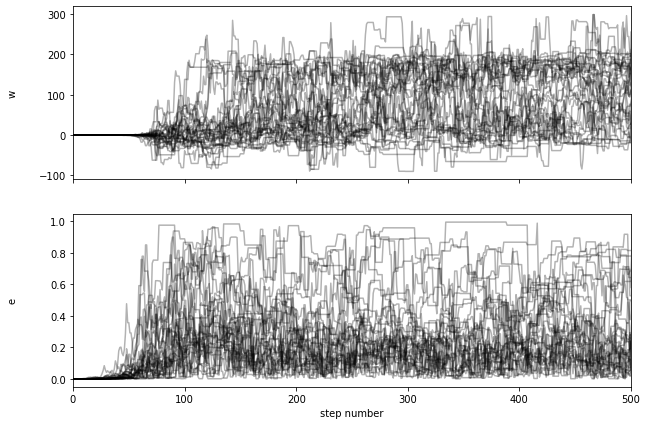

In [256]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["w", "e"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlim(0, 500)

axes[-1].set_xlabel("step number");

In [257]:
import corner

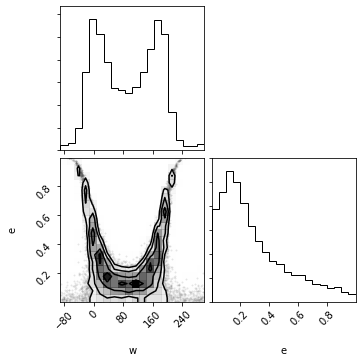

In [258]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=labels)